In [88]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [27]:
def Smooth(f,x):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    fx = ksmooth.locpoly(x,f,bandwidth = H)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

In [3]:
def Stack(wv,flgrid,errgrid,contam):
#     for i in range(len(flgrid)):
#         flgrid[i][contam[i]**2 / (errgrid[i]**2 - contam[i]**2) > 1] = 0
#         errgrid[i][contam[i]**2 / (errgrid[i]**2 - contam[i]**2) > 1] = 1E5
    
    
    flgrid = np.transpose(flgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    
    return stack, err

In [143]:
# grp = multifit.GroupFLT(grism_files = glob(dpath+'Grism_fields/GS3/*GrismFLT.fits'))

beams = grp.get_beams(42113, size=20)
mb = multifit.MultiBeam(beams, fcontam=1.0)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/

In [144]:
g102 = mb.oned_spectrum()['G102']
g141 = mb.oned_spectrum()['G141']

Bwv = g102['wave']
Bflx = g102['flux'] / g102['flat']
Berr = g102['err'] / g102['flat']
Bflt = g102['flat']

Rwv = g141['wave']
Rflx = g141['flux'] / g141['flat']
Rerr = g141['err'] / g141['flat']
Rflt = g141['flat']

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we lo

<ErrorbarContainer object of 3 artists>

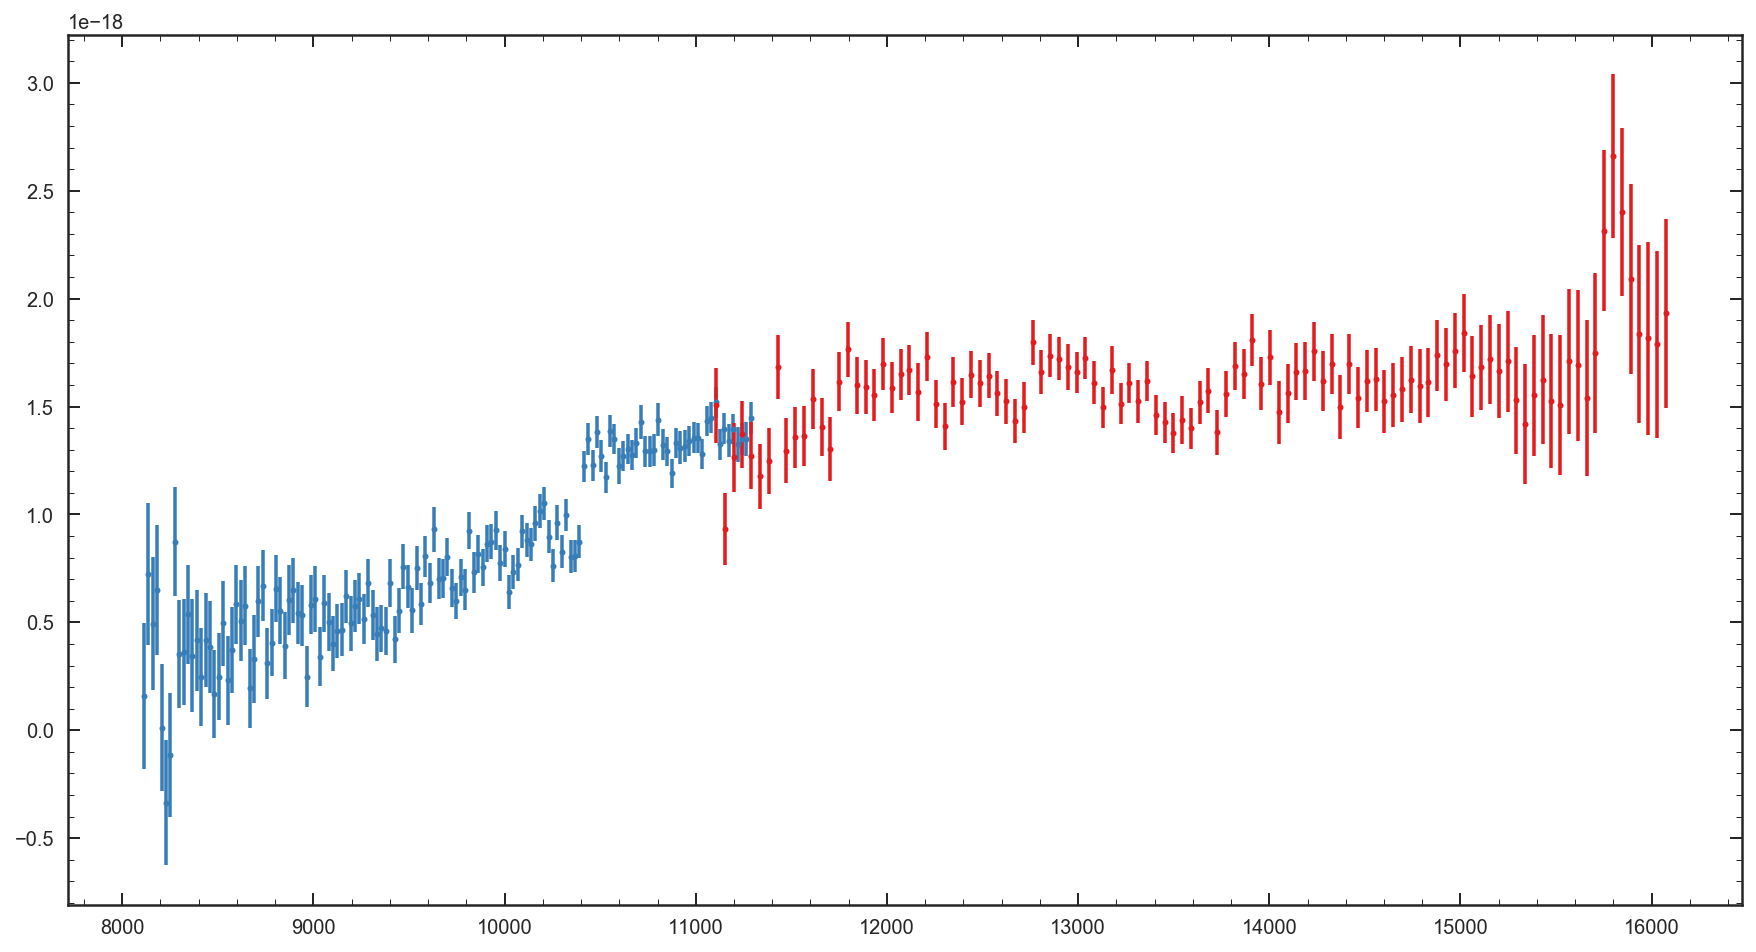

In [146]:
plt.figure(figsize=[15,8])

IDB = [U for U in range(len(Bwv)) if 8100 < Bwv[U] < 11300]
IDR = [U for U in range(len(Rwv)) if 11100 < Rwv[U] < 16100]

plt.errorbar(Bwv[IDB],Bflx[IDB],Berr[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rflx[IDR],Rerr[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

# plt.figure(figsize=[15,8])

# plt.errorbar(sp.Bwv,sp.Bflx,sp.Berr,
#             linestyle='None', marker='o', markersize=3, color='#377eb8')
# plt.errorbar(sp.Rwv,sp.Rflx,sp.Rerr,
#             linestyle='None', marker='o', markersize=3, color='#e41a1c')


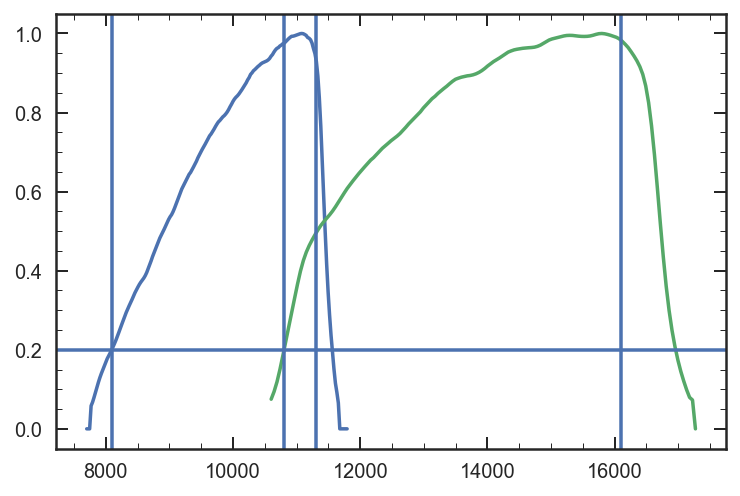

In [145]:
plt.plot(Bwv,Bflt / max(Bflt))
plt.plot(Rwv,Rflt / max(Rflt))
plt.axhline(0.2)
plt.axvline(8100)
plt.axvline(11300)
plt.axvline(10800)
plt.axvline(16100)

In [75]:
def Box_phot(wv,fl,er,input_phot, phot_width = 150):
    
    h=6.6260755E-27 # planck constant erg s
    c=3E10          # speed of light cm s^-1
    atocm=1E-8  
    
    sens_wv = np.array([U for U in wv if (input_phot - phot_width) < U < (input_phot + phot_width)])
       
    wave = wv * atocm
    filtnu = c /(sens_wv * atocm)
    nu = c / wave
    fnu = (c / nu**2) * fl
    Fnu = interp1d(nu, fnu)(filtnu)
    ernu = (c/nu**2) * er
    Ernu = interp1d(nu, ernu)(filtnu)

    energy = 1 / (h *filtnu)

    top1 = Fnu * energy
    top = np.trapz(top1, filtnu)
    bottom1 = energy
    bottom = np.trapz(bottom1, filtnu)
    photonu = top / bottom

    tp = np.trapz(((np.log(sens_wv)) / sens_wv), sens_wv)
    bm = np.trapz(1 / sens_wv, sens_wv)

    wave_eff = np.exp(tp / bm)

    photo = photonu * (c / (wave_eff * atocm) ** 2)

    eff_wv = wave_eff
    photo = photo
    photo_er = Sig_int(filtnu, Ernu, np.ones(len(Ernu)), energy) * (c / (wave_eff * atocm) ** 2)
    
    return eff_wv, photo, photo_er

def Scale_spectra(bwv,bfl,ber,rwv,rfl,rer,pwv,pfl):
    Bp = []; Bs = []; Bsig = []
    Rp = [] ; Rs = []; Rsig = []

    IDb = [U for U in range(len(bwv)) if bfl[U]**2 > 0] 
    IDr = [U for U in range(len(rwv)) if rfl[U]**2 > 0] 
    
    for i in range(len(pwv)):
        if (min(bwv[IDb]) < pwv[i] - 150) and (max(bwv[IDb]) > pwv[i] + 150):
            eff_wv, phot, phot_er = Box_phot(bwv[IDb],Smooth(bfl[IDb],bwv[IDb]),ber[IDb], pwv[i])
            Bp.append(pfl[i]); Bs.append(phot); Bsig.append(phot_er)

        if (min(rwv[IDr]) < pwv[i] - 150) and (max(rwv[IDr]) > pwv[i] + 150):
            eff_wv, phot, phot_er = Box_phot(rwv[IDr],Smooth(rfl[IDr],rwv[IDr]),rer[IDr], pwv[i])
            Rp.append(pfl[i]); Rs.append(phot); Rsig.append(phot_er)

    bscale = Scale_model(np.array(Bs), np.array(Bsig), np.array(Bp))
    rscale = Scale_model(np.array(Rs), np.array(Rsig), np.array(Rp))    
    
    return bfl / bscale, ber / bscale, rfl / rscale, rer / rscale

In [151]:
Bflx2,Berr2,Rflx2,Rerr2 = Scale_spectra(Bwv, Bflx, Berr, Rwv, Rflx, Rerr,Pwv, Pflx)

(8000, 16200)

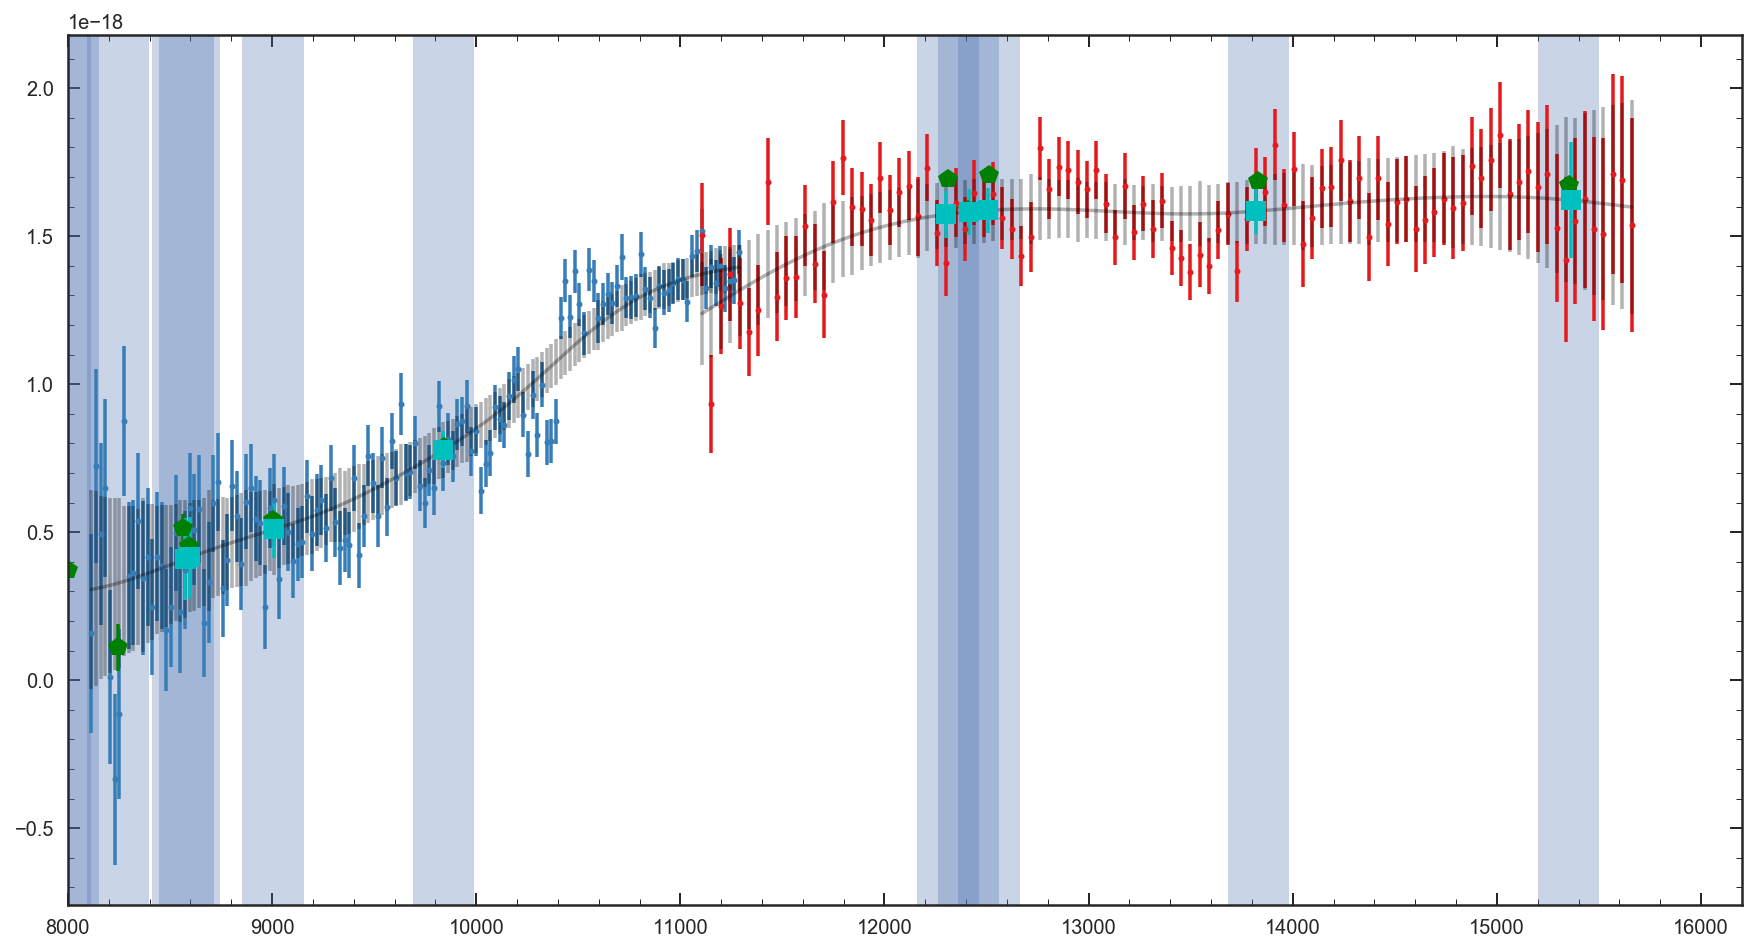

In [60]:
Pwv, Pflx, Perr, Pnum = np.load('../phot/GSD_42113_phot.npy')

plt.figure(figsize=[15,8])
plt.errorbar(Bwv[IDB],Bflx[IDB],Berr[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rflx[IDR],Rerr[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

plt.errorbar(Bwv[IDB],Smooth(Bflx[IDB],Bwv[IDB]),Berr[IDB],color='k', alpha = 0.3)
plt.errorbar(Rwv[IDR],Smooth(Rflx[IDR],Rwv[IDR]),Rerr[IDR],color='k', alpha = 0.3)

plt.errorbar(Pwv, Pflx, Perr,
            linestyle='None', marker='p', markersize=10, color='G')

Bp = []; Bs = []; Bsig = []
Rp = [] ; Rs = []; Rsig = []

for i in range(len(Pwv)):
    plt.axvspan(Pwv[i] - 150 , Pwv[i] +150, alpha=0.3)
    
    if (min(Bwv[IDB]) < Pwv[i] - 150) and (max(Bwv[IDB]) > Pwv[i] + 150):
        eff_wv, phot, phot_er = Box_phot(Bwv[IDB],Smooth(Bflx[IDB],Bwv[IDB]),Berr[IDB], Pwv[i])
        Bp.append(Pflx[i]); Bs.append(phot); Bsig.append(phot_er)
        
        plt.errorbar(eff_wv, phot, phot_er,linestyle='None', marker='s', markersize=10, color='c')
    
    if (min(Rwv[IDR]) < Pwv[i] - 150) and (max(Rwv[IDR]) > Pwv[i] + 150):
        eff_wv, phot, phot_er = Box_phot(Rwv[IDR],Smooth(Rflx[IDR],Rwv[IDR]),Rerr[IDR], Pwv[i])
        Rp.append(Pflx[i]); Rs.append(phot); Rsig.append(phot_er)

        plt.errorbar(eff_wv, phot, phot_er,linestyle='None', marker='s', markersize=10, color='c')
        
plt.xlim(8000,16200)

(8000, 16200)

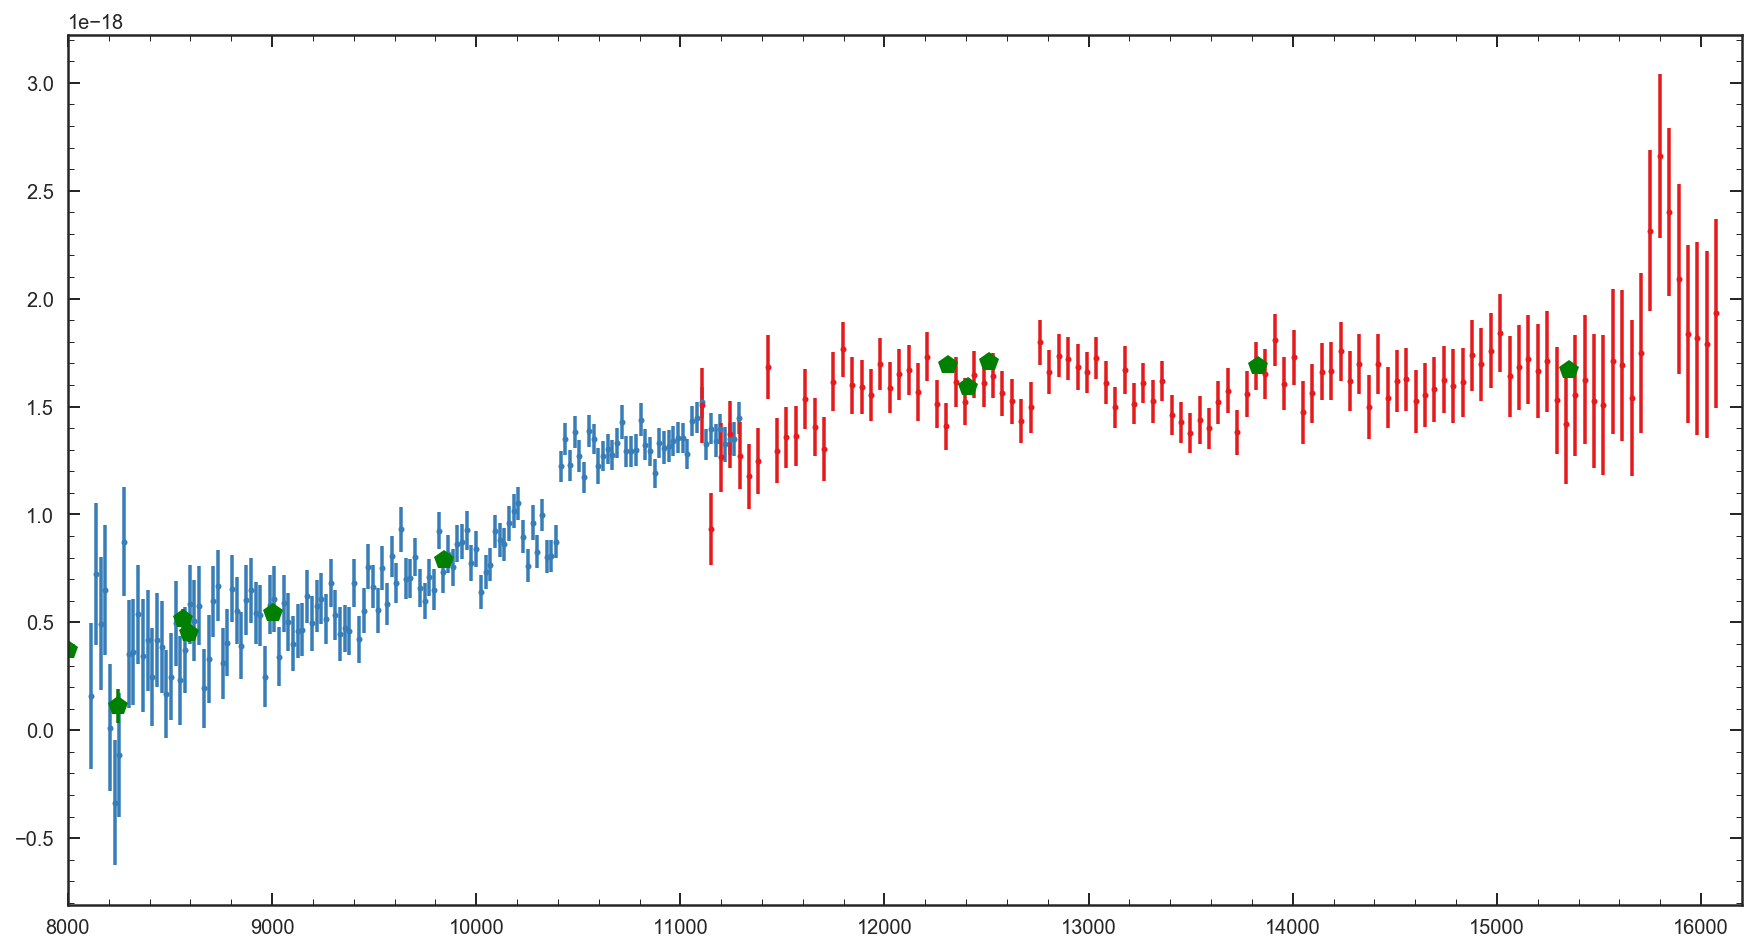

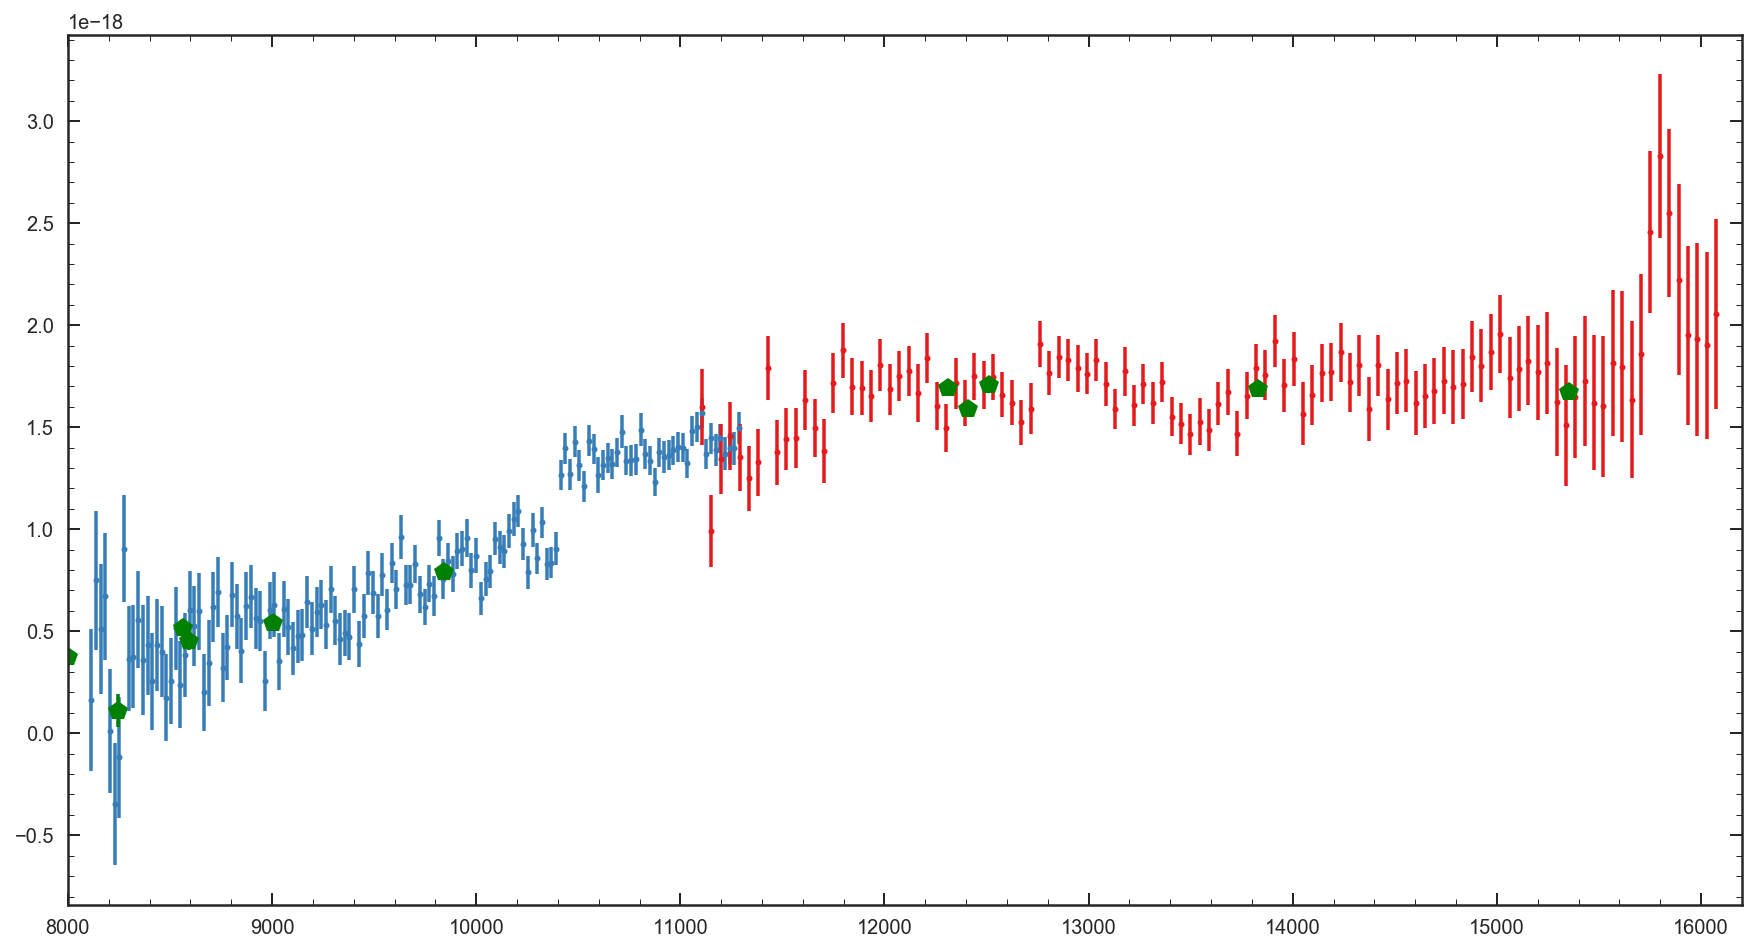

In [152]:
plt.figure(figsize=[15,8])
plt.errorbar(Bwv[IDB],Bflx[IDB],Berr[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rflx[IDR],Rerr[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

plt.errorbar(Pwv, Pflx, Perr,
            linestyle='None', marker='p', markersize=10, color='G')
plt.xlim(8000,16200)

plt.figure(figsize=[15,8])

plt.errorbar(Bwv[IDB],Bflx2[IDB],Berr2[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rflx2[IDR],Rerr2[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')


plt.errorbar(Pwv, Pflx, Perr,
            linestyle='None', marker='p', markersize=10, color='G')
plt.xlim(8000,16200)

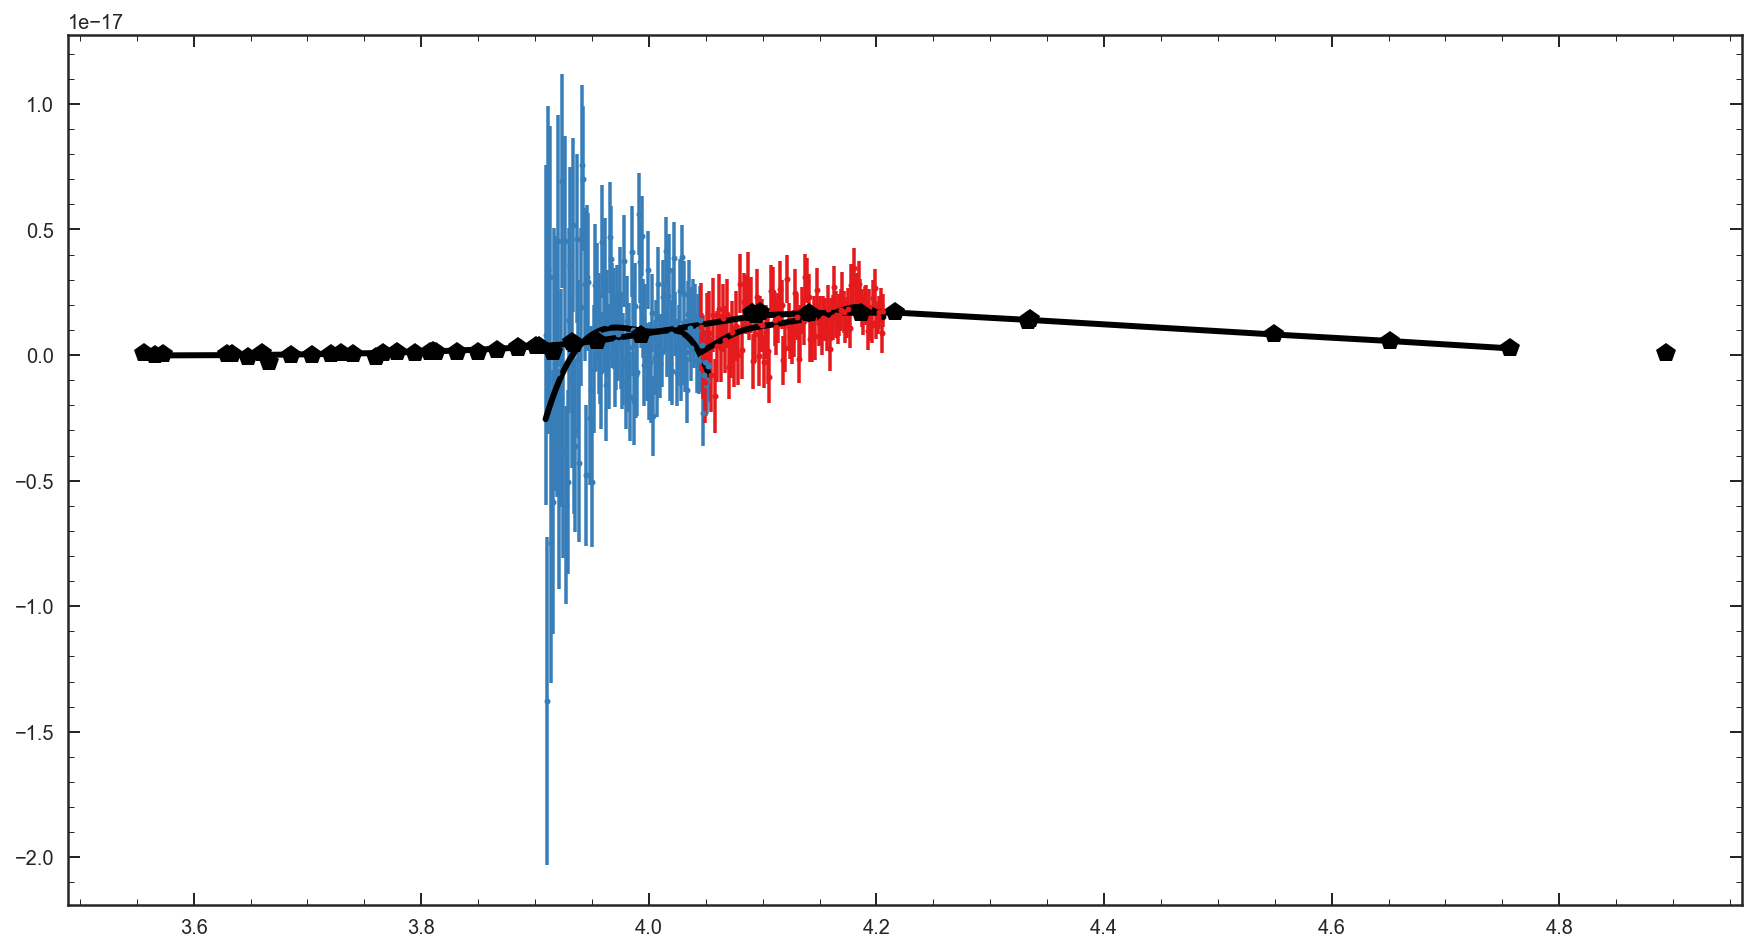

In [148]:
def Smooth(f,x):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    fx = ksmooth.locpoly(x,f,bandwidth = H)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

plt.figure(figsize=[15,8])
plt.errorbar(np.log10(Bwv[IDB]),Bflx2[IDB],Berr2[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.plot(np.log10(Bwv[IDB]), Smooth(Bflx2[IDB], Bwv[IDB]),'k', linewidth=3)

plt.errorbar(np.log10(Rwv[IDR]),Rflx2[IDR],Rerr2[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Rwv[IDR]), Smooth(Rflx2[IDR], Rwv[IDR]),'k', linewidth=3)
plt.errorbar(np.log10(Pwv), Pflx, Perr,
            linestyle='None', marker='p', markersize=10, color='k')
plt.plot(np.log10(Pwv[np.argsort(Pwv)]), Smooth(Pflx[np.argsort(Pwv)], Pwv[np.argsort(Pwv)]),'k', linewidth=3)

# plt.axvline(3934.777,linestyle='--', alpha=.3)
# plt.axvline(3969.588,linestyle='--', alpha=.3)
# plt.axvline(4102.89,linestyle='--', alpha=.3)
# plt.axvline(4305.61,linestyle='--', alpha=.3)
# plt.axvline(4341.68,linestyle='--', alpha=.3)
# plt.axvline(4862.68,linestyle='--', alpha=.3)
# plt.axvline(5176.7,linestyle='--', alpha=.3)
# plt.axvspan(3910, 3980, color='k', alpha=.1)
# plt.axvspan(3980, 4030, color='k', alpha=.1)
# plt.axvspan(4080, 4120, color='k', alpha=.1)
# plt.axvspan(4250, 4380, color='k', alpha=.1)
# plt.axvspan(4810, 4910, color='k', alpha=.1)
# plt.axvspan(5120, 5240, color='k', alpha=.1)



In [109]:
bpas= []
rpas= []

pa = -1
for i in beams:
    if i.grism.filter == 'G102':
        if pa != i.get_dispersion_PA():
            pa = i.get_dispersion_PA()
            bpas.append(pa)
pa = -1            
for i in beams:
    if i.grism.filter == 'G141':
        if pa != i.get_dispersion_PA():
            pa = i.get_dispersion_PA()
            rpas.append(pa)      


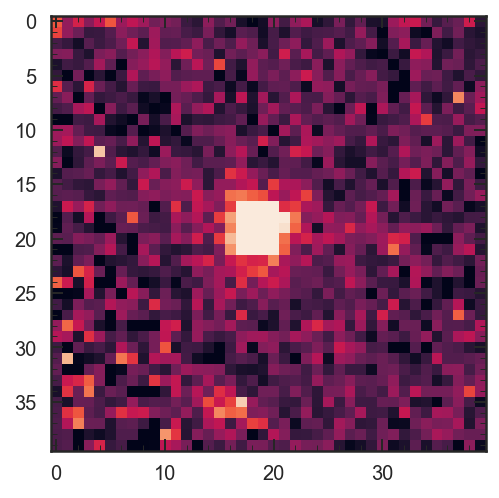

In [147]:
plt.imshow(np.arcsinh(beams[7].beam.direct), interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=1E-20)

In [121]:
co.beam.direct

array([[-7.8129737e-23, -2.8213046e-22,  4.6761392e-22, ...,
        -7.1239724e-22,  2.5623989e-22,  6.6993971e-22],
       [-4.6769607e-22,  1.1395424e-21, -7.0922897e-22, ...,
        -2.1425161e-21,  1.6511760e-21,  3.2535330e-22],
       [-1.0388221e-21,  7.9697862e-22,  2.5486705e-22, ...,
        -8.6408082e-22,  5.5929991e-22, -1.0440280e-21],
       ...,
       [-3.0401162e-22, -2.2999615e-22, -9.4847744e-23, ...,
        -8.1448962e-22, -6.0796836e-22, -8.5454523e-22],
       [ 1.1427353e-21, -2.2338824e-22, -3.8159386e-22, ...,
         1.2927779e-21, -8.1170763e-22,  9.4992838e-22],
       [ 6.2646643e-22, -1.4927792e-21, -7.6209608e-22, ...,
         3.1960173e-22,  5.6965527e-22, -7.9346104e-22]], dtype=float32)